#### Part A: Preprocessing and Initial Setup.

In [1]:
 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import Isomap


In [2]:


# Loading arff file yeat datset
data, _ = arff.loadarff("yeast.arff")
df = pd.DataFrame(data)

# showing shape and intialdata
print(df.shape)
print(df.head())


(2417, 117)
       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   
3  0.119092  0.004412 -0.002262  0.072254  0.044512 -0.051467  0.074686   
4  0.042037  0.007054 -0.069483  0.081015 -0.048207  0.089446 -0.004947   

       Att8      Att9     Att10  ...  Class5  Class6  Class7  Class8  Class9  \
0  0.041850  0.066938 -0.056617  ...    b'0'    b'0'    b'1'    b'1'    b'0'   
1 -0.077933 -0.080529 -0.016267  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
2  0.013646 -0.040666 -0.024447  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
3 -0.007670  0.079438  0.062184  ...    b'0'    b'0'    b'0'    b'0'    b'0'   
4  0.064456 -0.133387  0.068878  ...    b'1'    b'1'    b'0'    b'0'    b'0'   

   Class10  Class11  Class12  Class13  Class14  
0     b

* The dataset has 2417 rows and 117 columns. The attribute values are floats, and the class values are stored as byte strings. As per the assignment, we'll split the data into 103 attribute columns and 14 class columns.

#### Dimensionality Check:

In [3]:
# Separating attributes (first 103 columns) and labels remaining 14 (last 14 columns)
X = df.iloc[:, :-14]
Y = df.iloc[:, -14:]

print("Number of data points:", X.shape[0])
print("Number of features:", X.shape[1])
print("Number of labels:", Y.shape[1])


Number of data points: 2417
Number of features: 103
Number of labels: 14


#### Label Selection for Visualization

In [4]:
# checking the number of single labelled
((Y.astype('int').sum(axis=1)) == 1).sum()

np.int64(32)

& As you can see, it only have 32 datapoints that have single labels.

When  checked the labels, we found only 32 samples that have a single label as per above code block, and all of them are from Class1 which can be seen in next code block. No other class appears alone, they only appear together with others.
Because of this, cannot select two single-label classes. Instead, we used three groups:

* Class1 (single-label) ( cant' select others, as there exist only one class that exist as single label class.

* the most common multi-label combination,

*and all other cases as “Other.”



In [5]:
# Converting byte strings to integers
Y_clean = Y.map(lambda x: int(x.decode('utf-8')))

# finding the samples that has got single class labels, not distinguising becase using print statement which will be shown below, there is only one class 1 as single label.
single_label_rows = Y_clean[Y_clean.sum(axis=1) == 1]
top_single = single_label_rows.sum().sort_values(ascending=False).index.tolist() # just for the sake of filteringm filtering top 2
print(single_label_rows)
print(top_single)


# similar to single here we are gettign all the labels that are more than 1 label.. we select the top frequency from here )
multi_label_rows = Y_clean[Y_clean.sum(axis=1) > 1]
top_multi = tuple(multi_label_rows.value_counts().index[0])


# using those 3 categories
def labelling(row):
    if row.sum() == 1:
        if row[top_single[0]] == 1:
            return top_single[0]
    if tuple(row) == top_multi:
        return "Top-Multi"
    return "Other"

Y_clean["Category"] = Y_clean.apply(labelling, axis=1)
print(Y_clean["Category"].value_counts())


      Class1  Class2  Class3  Class4  Class5  Class6  Class7  Class8  Class9  \
171        1       0       0       0       0       0       0       0       0   
524        1       0       0       0       0       0       0       0       0   
552        1       0       0       0       0       0       0       0       0   
674        1       0       0       0       0       0       0       0       0   
692        1       0       0       0       0       0       0       0       0   
734        1       0       0       0       0       0       0       0       0   
893        1       0       0       0       0       0       0       0       0   
901        1       0       0       0       0       0       0       0       0   
1027       1       0       0       0       0       0       0       0       0   
1064       1       0       0       0       0       0       0       0       0   
1124       1       0       0       0       0       0       0       0       0   
1139       1       0       0       0    

* The category distribution is highly imbalanced. Most samples belong to "Other" (2148), while "Top-Multi" has 237 and "Class1" only 32. I'm not going to balance the data since this task is focused on dimensionality reduction, not classification. By the way, already explain in previous markdown text, why I am going forward with three classes only, partly because of data.

#### Scaling

In [6]:
Y_clean["Category"].value_counts()

Category
Other        2148
Top-Multi     237
Class1         32
Name: count, dtype: int64

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



 * We generally scale the data for all dimensionality reduction algorithms like PCA now tsne, which uses distances to find patterns. Suppose feature A has bigger values than others, it will dominate over otehr features and reduce the effect of otehr features and dominate the results, this  feature scaling makes sures the fair treatment to all the features. ( I can scale target column like the previous pca assignment, but I tend to choose not to as this has better representation, and it is not being used for training, it's just for visual inspection).

#### : t-SNE and Veracity Inspection

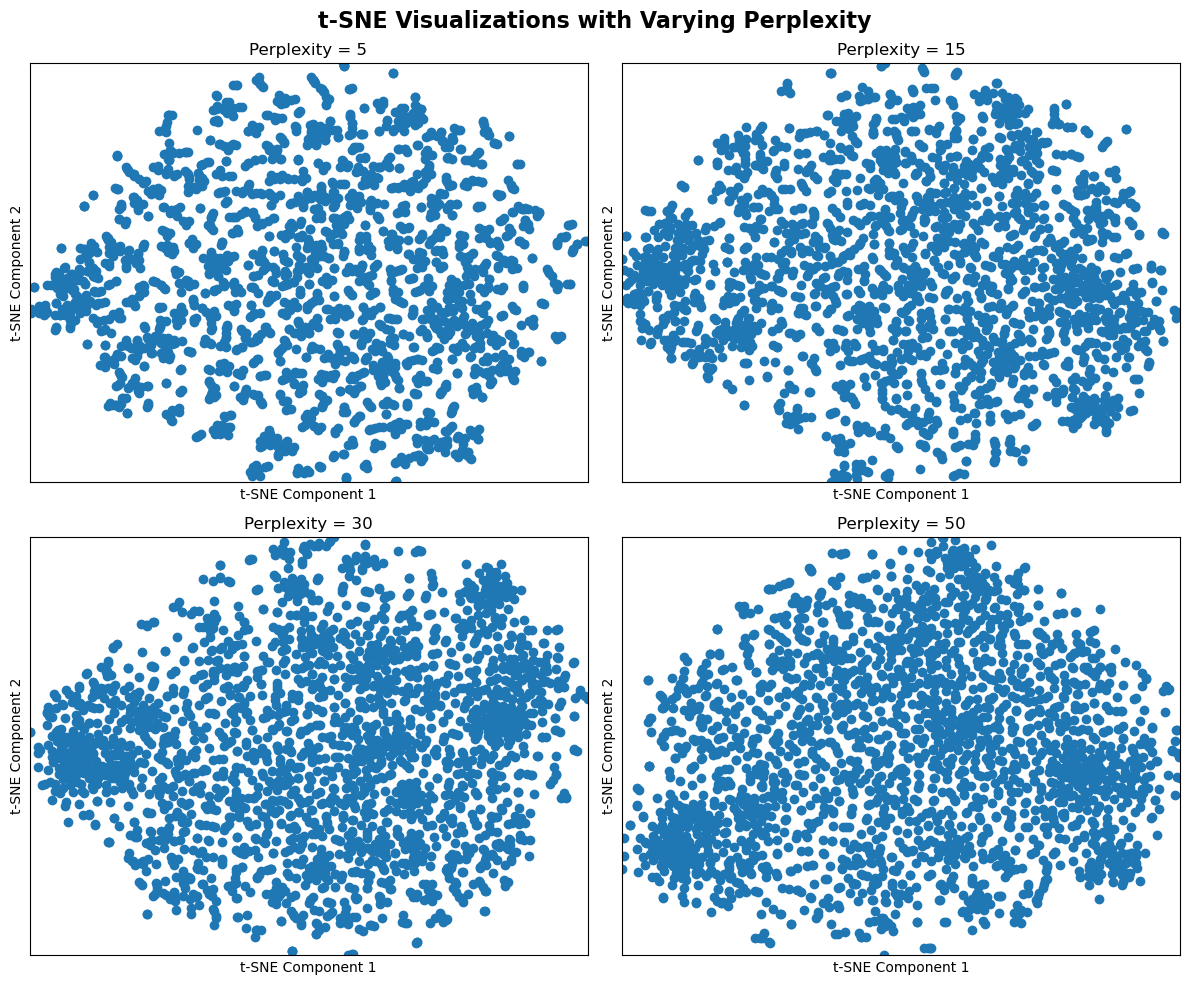

In [8]:
perplexities = [5, 15, 30, 50]
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # 4 subplots for 4 perplexities

# plotting suptitle
fig.suptitle("t-SNE Visualizations with Varying Perplexity", fontsize=16, fontweight='bold')

# colorblind freinidly
sns.set_palette("colorblind")

selecting_axes=axes.flatten()
for ax, p in zip (selecting_axes, perplexities):
    tsne = TSNE(n_components=2, perplexity=p, random_state=0) # here zero for same intialization, so we can find graphs for all three perplexities ith same intialization
    tsnex = tsne.fit_transform(X_scaled)

    ax.scatter(tsnex[:, 0], tsnex[:, 1])
    ax.set_title(f"Perplexity = {p}", fontsize=12)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_xlim(tsnex[:, 0].min(), tsnex[:, 0].max())
    ax.set_ylim(tsnex[:, 1].min(), tsnex[:, 1].max())
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')

plt.tight_layout()
plt.show()


*-- From the above plots, we can see how the data intailly has intially with 5, just noisy small groups, which clearly missed to see global pattern of all data(we discuss this in iso map in the nenxt question).

- Perplexity = 5  here only very close neighbors considered. Data looks noisy, no real cluster patterns are seen.

- Perplexity = 15  here slightly clusters start to appear, but still too many small groups, and data is still sparse.
( so weed need it to be less sparse and more clusters or capturing both global and closer data (which actually tsne does, represent closer groups closer in lower d from higher d)

- Perplexity = 30 → Clearer clusters, less sparse, good balance between local structure and global pattern..

- If we go higher than 30, the risk is you smooth too much, clusters may be better or merger, and you lose the “shorter distance” relationships (local detail), so there fore for good balancing, I'm sticking although 50 is not actually bad beuase we can still see clusters and sparse data, but clusters are not as clear as for 30, and seems merged. So, going ahead with 30.



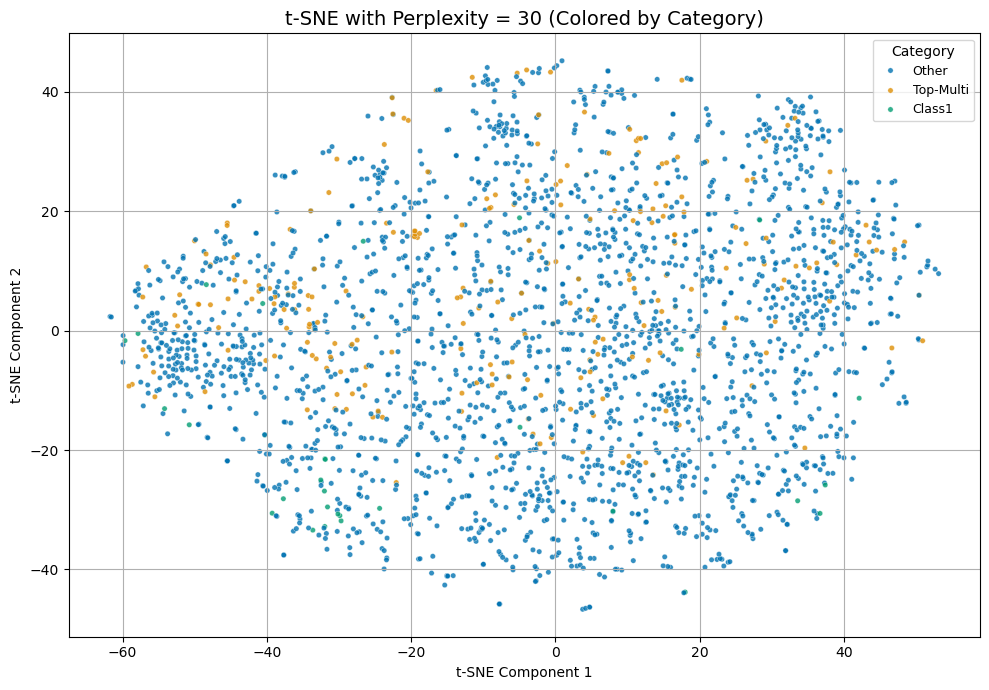

In [9]:
# Run t-SNE with perplexity 30
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)  # renamed from tsne_result

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE-1", "TSNE-2"])
tsne_df["Category"] = Y_clean["Category"].values 

# Plot with colorblind-friendly palette
plt.figure(figsize=(10, 7))
sns.set_palette("colorblind")
sns.scatterplot(data=tsne_df, x="TSNE-1", y="TSNE-2", hue="Category", s=15, alpha=0.8)

plt.title("t-SNE with Perplexity = 30 (Colored by Category)", fontsize=14)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Category", loc="best", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


* The image shows the entire data with their necessary class labels. You can see that labels other in blue which are majority of the points and top mulitiple class frequency label which is 272 points in orange, and 32 values of class1 which are single labels.
* From the plot there is asctually so clear distincion between three. Most of the class 1 are on the left side, but wr cannot distinguish either because of noise, and you can see regoins are mixed with mulitple classes altogeter, which can be very hard to learn pattern to detect classes.

Reasons:
1)multilabel changed in to a single categorry, and because of data issues we area able to have only 3 categories, and because of this, other category has around(2148), while "Top-Multi" has 237 and "Class1" only 32 samples leadign to high imbalance.

#### Veracity Inspection [10]:

##### 1. NOISY/AMBIGUOUS LABELS

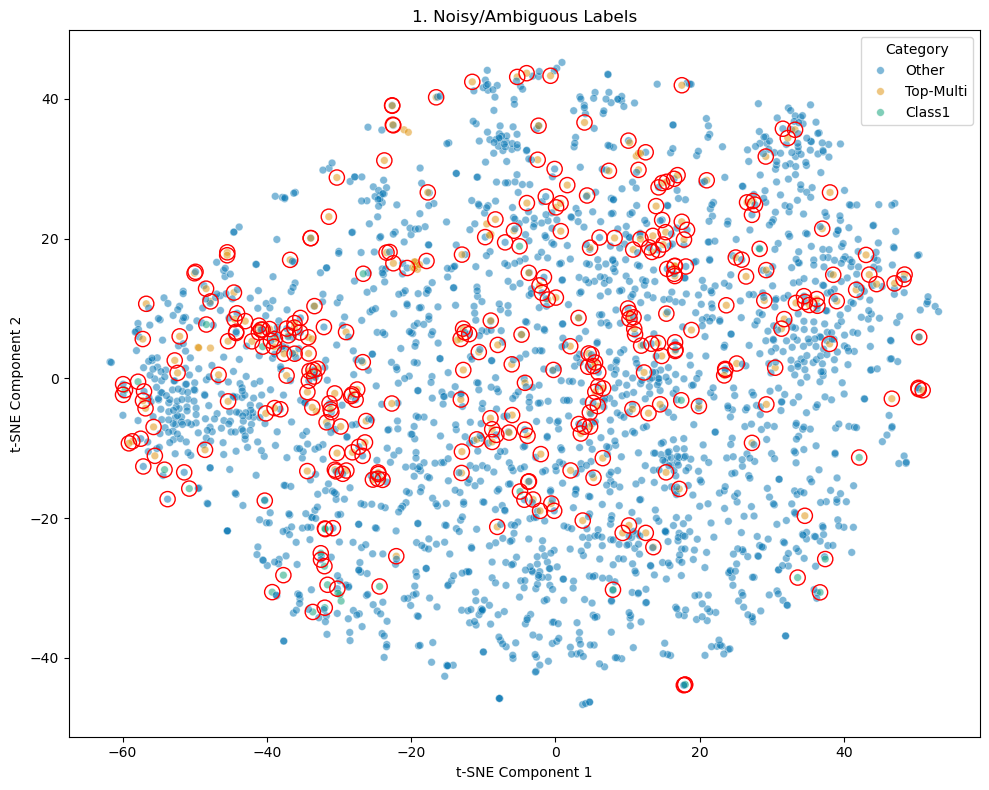

Noisy samples: 333 points


In [10]:
# Calculating pairwaise distances, to make sure we dont have noise or overalapping datas.
distances = squareform(pdist(X_tsne))
categories = Y_clean["Category"].values

# for every point, checking 3 nearest labels, and if it has more than 2 differnt labels than the datapoint nearr it, we can think this is noise, because 5 willbe very close alomost merging, and 3 of them are different..
noisy = []
for i in range(len(X_tsne)):
    nearest_4 = np.argsort(distances[i])[1:4]
    neighbor_cats = categories[nearest_4]
    if sum(neighbor_cats != categories[i]) >= 2:
        noisy.append(i)
noisy = np.array(noisy)  # this holds only the indices of points that were flagged as nois


# plotting scatter plot and also circling up all the point on we found their 2 out of 3 neighbors has other class, which means they re oveerlapped.
plt.figure(figsize=(10, 8))
sns.set_palette("colorblind")
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=Y_clean["Category"], s=30, alpha=0.5)
if len(noisy) > 0:
    plt.scatter(X_tsne[noisy,0], X_tsne[noisy,1], facecolors='none', edgecolors='red', s=120, linewidths=1, label='Noisy Labels', marker='o')
plt.title("1. Noisy/Ambiguous Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

print(f"Noisy samples: {len(noisy)} points")




* The above plot shows all the noisy datapoints, and we can clearly see that many of the samples labeled as Class1 or Top-Multi are actually surrounded by points from the 'Other' category. If you look at the image, this overlap is visible, in previous image without circles. Some outlier points are also circled—like the ones at the bottom even though their closest neighbors are far away, those can be considered asoutliers. Still, there’s a huge amount of label mixing happening across regions. Using 3 neighbors gave me a way to detect noise, like if a point has at least 2 neighbors with different labels, we can assume it’s overlapping or noise..

* using 3 neighbors tells, we can estimate if it can overlap, similarly if we use 10 neighbors, it will give use the mixed up and hard to learn samples, because with 10 neighbours we can clearly tell that they are thouruougly mixed neighbors.

( **please note that some points, being at longer distances, when their nearby neigbhours are conidererd, there is no actual overlap, most of such noisy labelled datapoints although no overlap, can be outliers, beucause of their distance to nearby neighbours.**)

### 2. Outliers  
(Same distance method, but here we check if the average distance of each point to all oher points is higher than what most points have. Basically, if a point is far from everything else, we mark it as an outlier.)


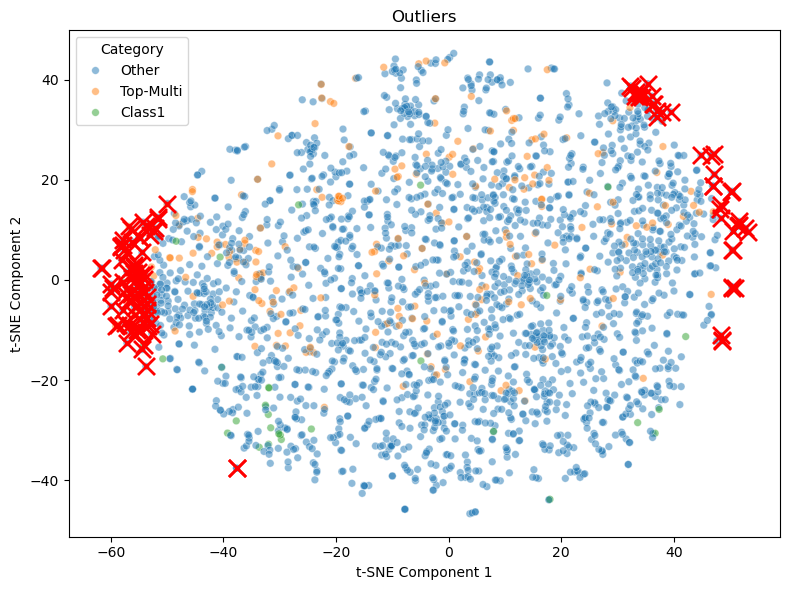

the number of outliers  from the new labelled dataset are, 121


In [11]:
# avg distances for each point, and we are taking average.
avg_dist = distances.mean(axis=1)
# outliers like basicaly if a point is far from eveything else, but we use over 95 percent, to find the extreme outliers
outliers = avg_dist > np.percentile(avg_dist, 95)



plt.figure(figsize=(8, 6))
sns.set_palette("colorblind")
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=Y_clean["Category"], palette="tab10", s=30, alpha=0.5)

if outliers.sum() > 0:
    plt.scatter(X_tsne[outliers,0], X_tsne[outliers,1], c='red', s=150, marker='x', linewidths=2, label='Outliers')
plt.title("Outliers")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()


print(f"the number of outliers  from the new labelled dataset are, { outliers.sum()}")

#### 3  Hard-to-Learn Samples [3] * (Same method as noisy label detection, but instead of using 3 neighbors to check for overlap, we now use 10 neighbors to find samples that are thoroughly mixed and harder to learn.)

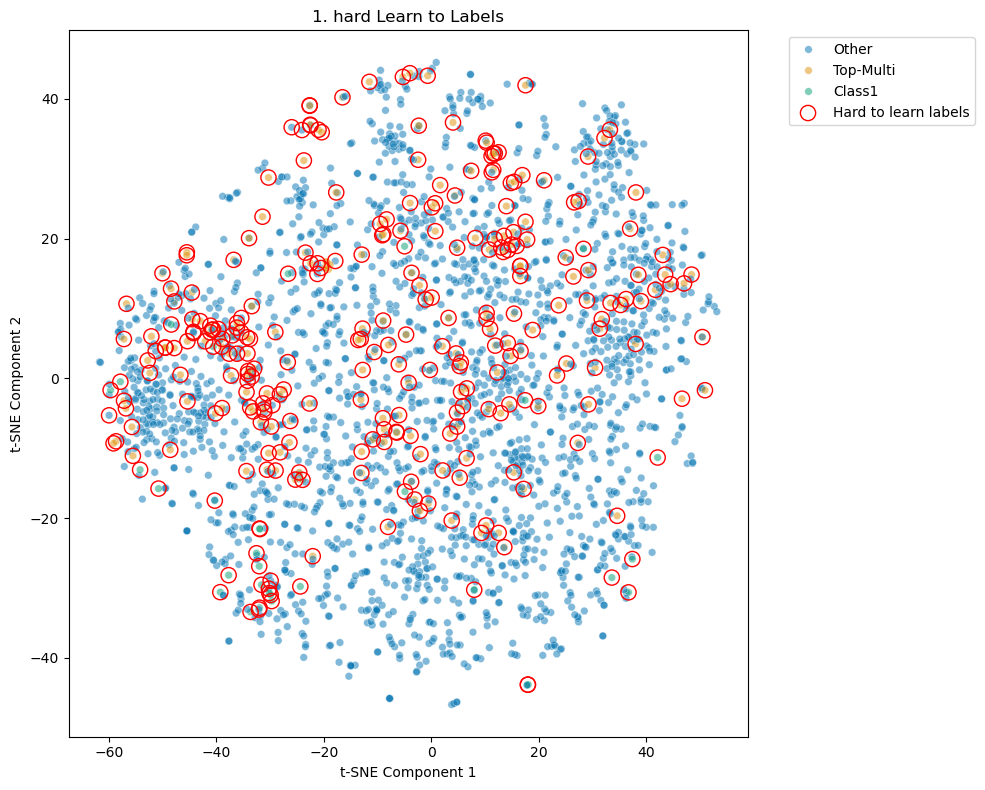

Hard-to-learn samples: 291 points


In [12]:
# Calculating pairwaise distances, to make sure we dont have noise or overalapping datas.
distances = squareform(pdist(X_tsne))
categories = Y_clean["Category"].values

hardto = []
for i in range(len(X_tsne)):
    nearest_10 = np.argsort(distances[i])[1:11]
    neighbor_cats = categories[nearest_10]
    if sum(neighbor_cats != categories[i]) >= 5:
        hardto.append(i)
hardto = np.array(hardto)  # t holds only the indices of points that were flagged as nois



plt.figure(figsize=(10, 8))
sns.set_palette("colorblind")
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], 
                hue=Y_clean["Category"], s=30, alpha=0.5)
if len(noisy) > 0:
    plt.scatter(X_tsne[hardto,0], X_tsne[hardto,1], facecolors='none', edgecolors='red', s=120, linewidths=1, label='Hard to learn labels', marker='o')
plt.title("1. hard Learn to Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



print(f"Hard-to-learn samples: {len(hardto)} points")



##### Reasoning for this plot above:

Using just 3 neighbors and their distances helps estimate whether a point is locally overlapped by other categories liek we did in noise labels.

But when we use 10 neighbors, we get a clearer picture of whether a sample is surrounded by mixed labels—indicating that it's not just noisy, but genuinely hard to learn, especially in regions where functional category colors are thoroughly mixed because we round it only it it has mmore than 5 neighbors out of 10 neighbors that are differnt labels, which tells 50 percent of neighbors are differnt labels.

All 291 samples identified here in graph show hard-to-learn patterns. Since each sample is fouund based on its 10 nearest neighbors and each of those neighbors influences 10 others, this effectively covers a large portion of the dataset, therefor making this effective for fnding hard to learn areas..


## Isomap and Manifold Learning

#### Isomap Implementation [5]:

In [13]:
# applying isomap on the scaled X

isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_scaled)
print("the new feature map with Isomap shape:", X_isomap.shape)
# reduced to 2 dimensions

the new feature map with Isomap shape: (2417, 2)


t-SNE converts closeness into a probability using normal distribution. If two points are close, the probability will be higher, and if they are far, the probability will be near zero, so it doesn't preserve any farther points relation. In lower dimensions, using Student-t distribution, it matches these probabilities, so in higher D the closer ones should also be closer in 2D. so again close strctures is preserved. If you look at the perplexity at part B, we saw that higher perplexity score formed clusters, whereas local ones didnot because it was not able to capture the global pattern.

Isomap on the other hand connects each point to its neighbors like in a graphm calculating geodesic distances, using these distances, after mapping to lower dimensions, it makes sure the distances are preserved, not just local structure like t-SNE but the overall global structure of the dataset.

#### Visualization [5]:

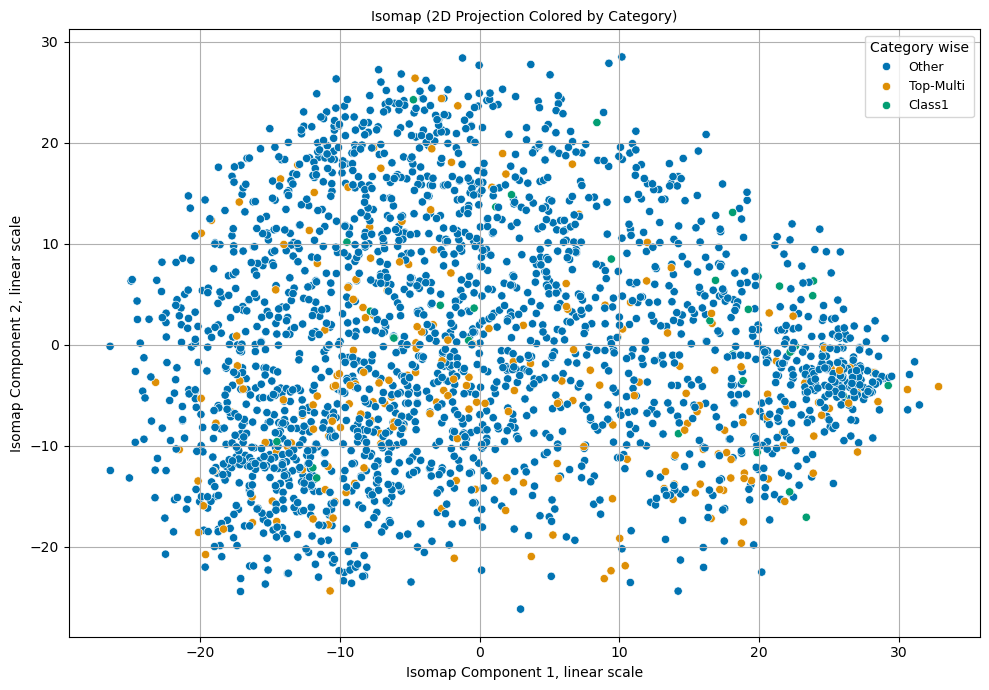

In [14]:
#same method of plotting like tsne earlier
isomap_df = pd.DataFrame(X_isomap, columns=["ISOMAP1", "ISOMAP2"])
isomap_df["Category"] = Y_clean["Category"].values

plt.figure(figsize=(10, 7))

# Use colorblind-friendly palette
sns.set_palette("colorblind")
sns.scatterplot(data=isomap_df, x="ISOMAP1", y="ISOMAP2", hue="Category")

# Title and axis labels
plt.title("Isomap (2D Projection Colored by Category)", fontsize=10)
plt.xlabel("Isomap Component 1, linear scale")
plt.ylabel("Isomap Component 2, linear scale")

# Legend styling
plt.legend(title="Category wise", fontsize=9)

# Grid and layout
plt.grid(True)
plt.tight_layout()
plt.show()


#### 1) Comparison: let's compare the above plot with tsne plot we ran with perplexity 30. which is added here below for reference.

t-SNE gave some clustering with 30 perplexity choosen, this tells that it mainly preserving local neighbor patterns.and the categories were still heavily overlapping, as we can see in the image below. Mathematically we already know that distances like smaller probablilites are considered minimal, so the farther points are not much preserved.

In Isomap, the data looks more widely spread out, and clusters are not as clearly visible compared to t-SNE. This shows that Isomap is not just focusing on local neighbors like t-SNE but is trying to capture the overall/global pattern of the data but not forming much localized cluser.

If we imagine the data lying on curved surfaces, Isomap preserves the distances between points along those curves. So even though there are overlaps Isomap does a better job at maintaining the global distances between data points ( which is likely because less visibiltiy of cluster formation, not foscused on forming tight clusters).

*NOTE* : AGAIN, JUST TO BE CLEAR, BECAUSE OF THE DATASET ISSUES, THE CATEGORIES DIVIDED DOESN'T HAVE CLEAR DIFFERENTION OF THREE LABELS BOTH IN ISO MAP AND TSNE, CALSSIFICATION IS HIGHLY IMPROBABLE IN THIS CASE AS PER THE DATA.



FIGURE BELOW: TSNE WITH 30 PERPLEXITY.
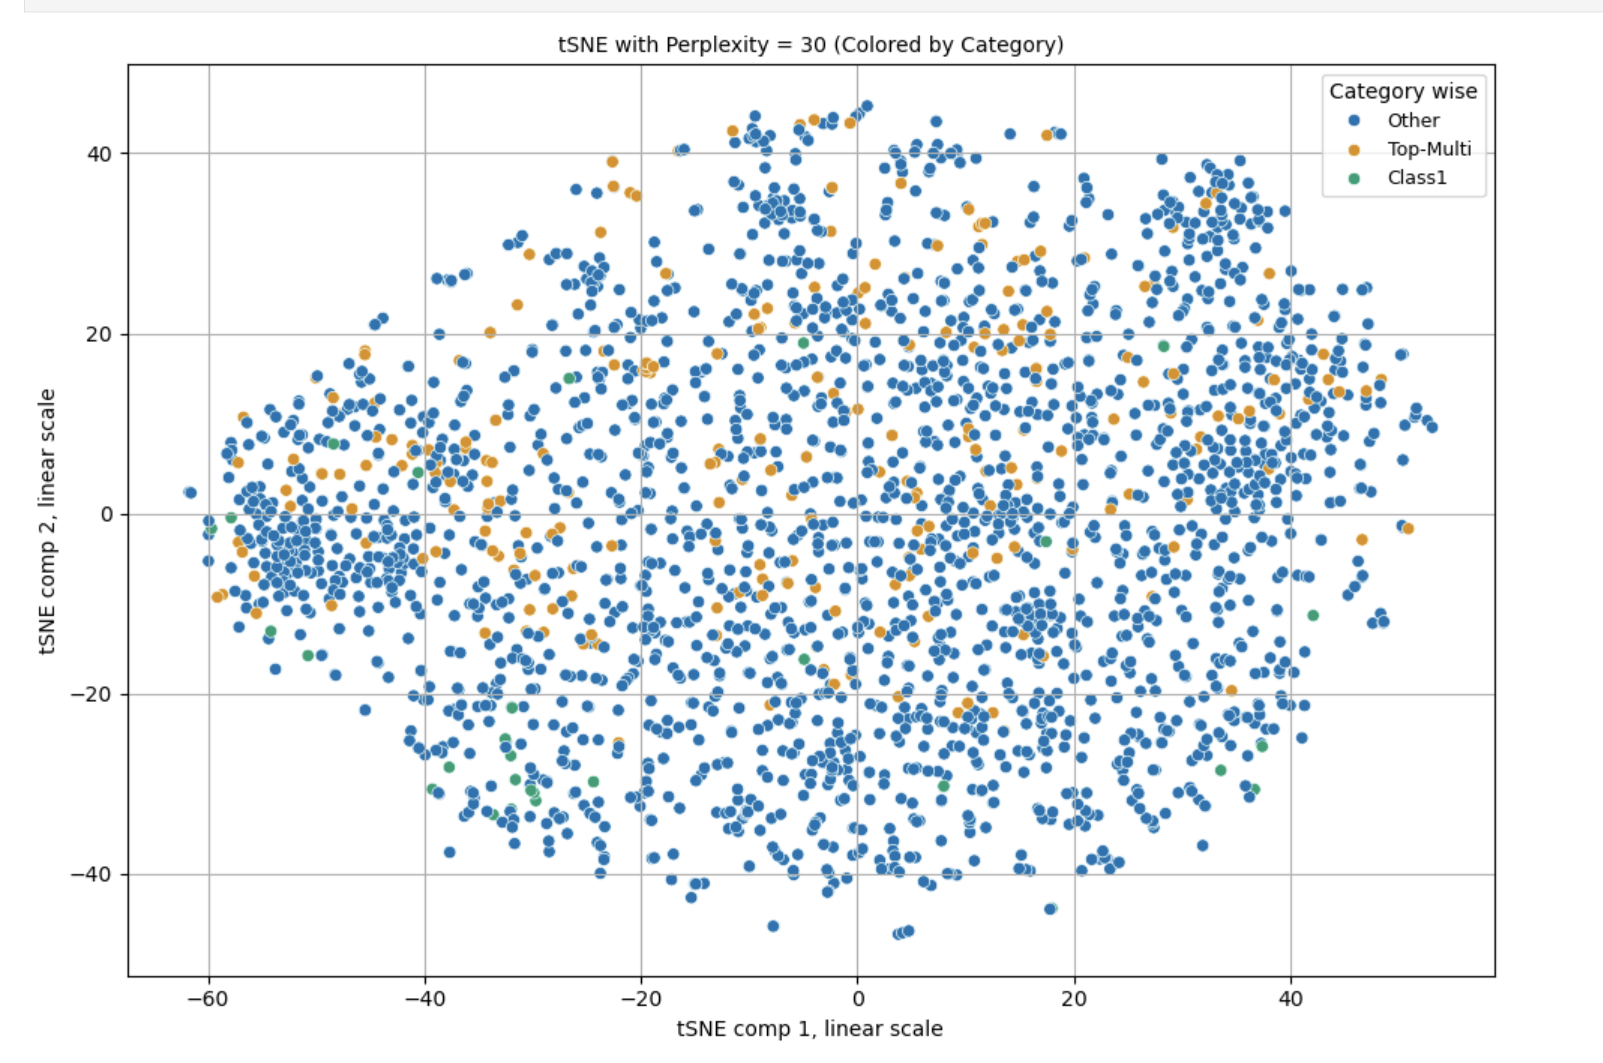



#### 2) data manifold:


As discussed in the previous manifold lecture, it's like a sheet of paper in 3D space, and the paper is always 2D, no matter if its flat or curved or twisted. This manifold learning will basically unfold that paper in 3D to reveal its true structure even if it is twisted or cumbled in higher dimensions. This says that rotating or streteching doesnt change it's fundamental 2d nature.

The  Isomap plot in previous block shows that there are no complex patters like spirals, with bare minimum clustering patters and is spread is smooth indicating curvature but without any complex structure, so this iso map is doesnot suggest a complex manifold. Along with this moderate compexity of manifold, no proper clusters, no proper divison boundaries between classes and smoothy spread distribution with noise and overalapped data, this is highly tiresome some classification.

